## Install Dependencies and Setup

In [1]:
!pip install tensorflow==2.13 opencv-python matplotlib

In [17]:
!pip list

Package                      Version
---------------------------- ---------
absl-py                      2.0.0
asttokens                    2.4.0
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.1
certifi                      2023.7.22
charset-normalizer           3.2.0
colorama                     0.4.6
comm                         0.1.4
contourpy                    1.1.1
cycler                       0.11.0
debugpy                      1.8.0
decorator                    5.1.1
executing                    1.2.0
flatbuffers                  23.5.26
fonttools                    4.42.1
gast                         0.4.0
google-auth                  2.23.0
google-auth-oauthlib         1.0.0
google-pasta                 0.2.0
grpcio                       1.58.0
h5py                         3.9.0
idna                         3.4
ipykernel                    6.25.2
ipython                      8.15.0
jedi                         0.19.0
jup

## Startup

In [2]:
import tensorflow as tf
import os

2023-09-23 12:17:29.204137: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 12:17:41.189964: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Add Images to data Folder

## Prune Images

In [12]:
import cv2
import imghdr

In [97]:
data_dir = 'data'

In [98]:
image_exts = ['jpeg','jpg','bmp','png']

In [99]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## Load Data

In [ ]:
tf.data.Dataset??

In [100]:
import numpy as np
from matplotlib import pyplot as plt

In [101]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 1414 files belonging to 2 classes.


In [105]:
data_iterator = data.as_numpy_iterator()

In [106]:
batch = data_iterator.next()

In [95]:
len(batch)

2

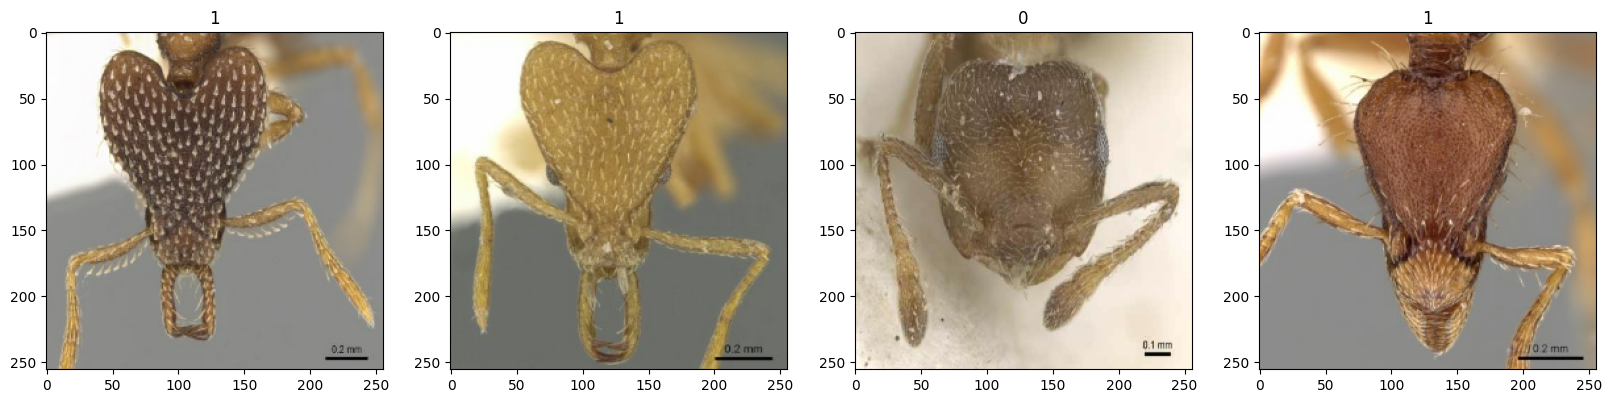

In [107]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 0 = Crematogaster, 1 = Strumigenys

## Scale Data

In [110]:
data = data.map(lambda x,y: (x/255, y))

In [111]:
data.as_numpy_iterator().next()

(array([[[[0.78039217, 0.75686276, 0.7019608 ],
          [0.78039217, 0.75686276, 0.7019608 ],
          [0.78039217, 0.75686276, 0.7019608 ],
          ...,
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294]],
 
         [[0.7863664 , 0.762837  , 0.70793504],
          [0.7863664 , 0.762837  , 0.70793504],
          [0.7863664 , 0.762837  , 0.70793504],
          ...,
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294]],
 
         [[0.7942708 , 0.7707414 , 0.71583945],
          [0.7942708 , 0.7707414 , 0.71583945],
          [0.7942708 , 0.7707414 , 0.71583945],
          ...,
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294],
          [0.48235294, 0.48235294, 0.48235294]],
 
         ...,
 
         [[0.46666667, 0.4862745 , 0.49803922],
          [0.46666

## Split Data

In [56]:
len(data)

45

In [112]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [113]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Build Deep Learning Model

In [114]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [124]:
model = Sequential()

In [125]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [126]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [127]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 30, 30, 16)       

## Train

In [119]:
logdir='logs'

In [128]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [129]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
31/31 [==============================] - 5s 102ms/step - loss: 0.6617 - accuracy: 0.7520 - val_loss: 0.3553 - val_accuracy: 0.8333
Epoch 2/15
31/31 [==============================] - 3s 102ms/step - loss: 0.3121 - accuracy: 0.8770 - val_loss: 0.2364 - val_accuracy: 0.8819
Epoch 3/15
31/31 [==============================] - 3s 104ms/step - loss: 0.1958 - accuracy: 0.9274 - val_loss: 0.1194 - val_accuracy: 0.9514
Epoch 4/15
31/31 [==============================] - 3s 102ms/step - loss: 0.1140 - accuracy: 0.9567 - val_loss: 0.1289 - val_accuracy: 0.9514
Epoch 5/15
31/31 [==============================] - 3s 102ms/step - loss: 0.0842 - accuracy: 0.9667 - val_loss: 0.1302 - val_accuracy: 0.9583
Epoch 6/15
31/31 [==============================] - 4s 105ms/step - loss: 0.0658 - accuracy: 0.9728 - val_loss: 0.1025 - val_accuracy: 0.9583
Epoch 7/15
31/31 [==============================] - 3s 103ms/step - loss: 0.0460 - accuracy: 0.9819 - val_loss: 0.1340 - val_accuracy: 0.9514
Epoch 

## Plot Performance

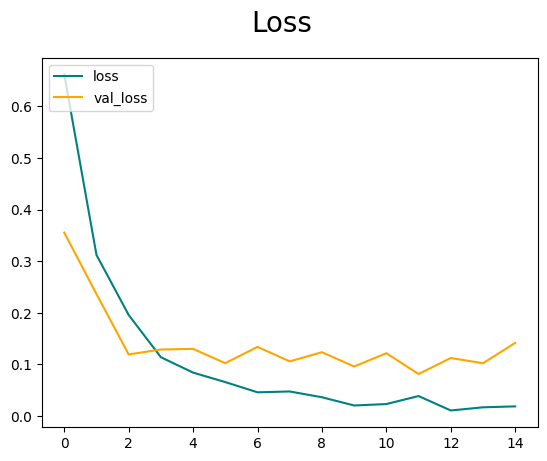

In [130]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

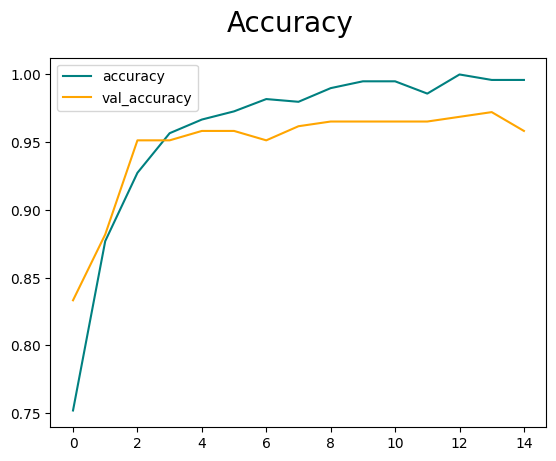

In [131]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate Performance of Model

In [76]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [77]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [78]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 22ms/step


In [80]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.9436619877815247, Recall:1.0, Accuracy:0.96875


## Test Performance of Model

In [ ]:
import cv2

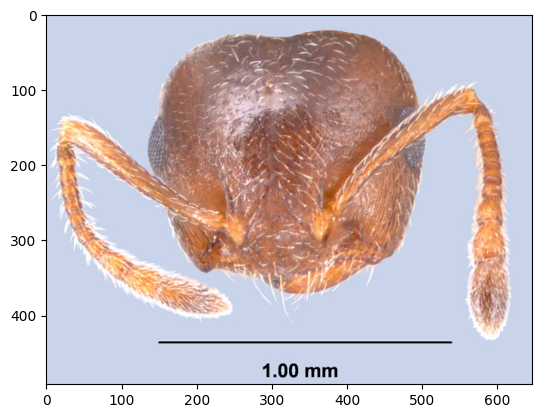

In [134]:
img = cv2.imread('crematogastertest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

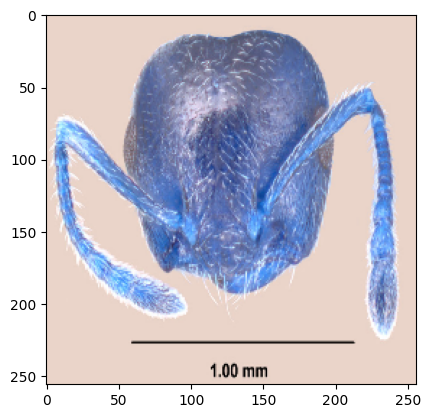

In [135]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [136]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 18ms/step


In [137]:
yhat

array([[0.09356386]], dtype=float32)

In [139]:
if yhat < 0.5: 
    print(f'Predicted class is Crematogaster')
else:
    print(f'Predicted class is Strumigenys')

Predicted class is Crematogaster


## Save Model

In [140]:
from tensorflow.keras.models import load_model

In [142]:
model.save(os.path.join('models','crematogaster-strumigenys.h5'))

In [ ]:
model.save(os.path.join('models','crematogaster-strumigenys.keras'))

In [143]:
new_model = load_model(os.path.join('models','crematogaster-strumigenys.keras'))

In [144]:
new_model

In [145]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 81ms/step


array([[0.09356386]], dtype=float32)